# Feature Extraction at Time Series Level for Clustering Nights
The following assumes that we have now selected a set of candidates where the night periods have been preprocessed to ensure that they are consistent and complete, with a consistent start and end time and candidates have been selected based broadly that they maximise the number of complete nights (determined by having zero missing intervals). Generating these features will provide the ability to look at the night periods as a whole, rather than individual intervals, and to cluster them based on their features. This is useful for clustering analysis, where we want to group similar nights together based on their features. The desire is to find patterns in the night periods that can be used to identify different types of nights, such as restful nights, restless nights, or nights with specific patterns of activity. This can help to identify different types of sleep disturbances or other activity that has an impact on the night period, and to provide insights into the underlying states of the patients during these periods.

In [82]:
%load_ext autoreload
%autoreload 2

import pandas as pd

from src.configurations import Configuration
from src.night_clustering import NightClustering

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [83]:
# Assumes pipeline has been run to provide the final filtered DataFrame config.final_filtered_csv
config = Configuration()
df = pd.read_csv(config.final_filtered_csv)
df['datetime'] = pd.to_datetime(df['datetime'])
df = df.set_index(['id', 'datetime'])
df.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 7694 entries, (np.int64(41131654), Timestamp('2019-09-12 18:00:00')) to (np.int64(86025410), Timestamp('2017-05-03 10:30:00'))
Data columns (total 18 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   iob mean   7694 non-null   float64
 1   cob mean   7680 non-null   float64
 2   bg mean    7694 non-null   float64
 3   iob min    7694 non-null   float64
 4   cob min    7680 non-null   float64
 5   bg min     7694 non-null   float64
 6   iob max    7694 non-null   float64
 7   cob max    7680 non-null   float64
 8   bg max     7694 non-null   float64
 9   iob std    6575 non-null   float64
 10  cob std    6544 non-null   float64
 11  bg std     6575 non-null   float64
 12  iob count  7694 non-null   int64  
 13  cob count  7694 non-null   int64  
 14  bg count   7694 non-null   int64  
 15  offset     7694 non-null   int64  
 16  day        7694 non-null   object 
 17  time       7694 non-null 

In [84]:
nan_counts = df.isna().sum()
print("Total NaNs per column:")
print(nan_counts)

Total NaNs per column:
iob mean        0
cob mean       14
bg mean         0
iob min         0
cob min        14
bg min          0
iob max         0
cob max        14
bg max          0
iob std      1119
cob std      1150
bg std       1119
iob count       0
cob count       0
bg count        0
offset          0
day             0
time            0
dtype: int64


In [85]:
df_isna = df[df['cob mean'].isna()]
print('Count of intervals with NaNs for COB columns, i.e. missing COB data.')
df_isna.groupby(by=['id','day'])['day'].count() # Check rows with NaNs in 'cob mean'

Count of intervals with NaNs for COB columns, i.e.e missing COB data.


id        day       
79526193  2017-05-25    1
          2017-05-27    2
          2017-05-28    4
          2017-05-30    1
          2017-06-13    1
          2017-06-18    2
86025410  2017-04-03    1
          2017-04-09    2
Name: day, dtype: int64

In [86]:
# Count number of consecutive NaNs in 'cob mean' column
df_reset = df_isna.reset_index().sort_values(['id', 'datetime'])
df_reset['time_diff'] = df_reset.groupby('id')['datetime'].diff().dt.total_seconds() / 60
df_reset.groupby('id')['time_diff'].apply(lambda x: (x == 30).sum())

id
79526193    2
86025410    1
Name: time_diff, dtype: int64

There are only three instances where these NaNs span greater than 30 minutes, which is the minimum interval between two consecutive COB measurements. This is very few and means that we can proceed with imputation of these NaNs in preparation for feature extraction.

In [87]:
df[['cob mean', 'cob min', 'cob max']] = df.groupby('id')[['cob mean', 'cob min', 'cob max']].transform(lambda x: x.interpolate(method='linear'))

Next, we need to select the columns that we want to extract features from. For the clustering of similar nights, we will use ['iob mean', 'cob mean', 'bg mean', 'cob max', 'iob max'] variables and extract additional features from these. The max variables are chosen because they may hold information about the peaks in the night periods, which may be indicative of specific patterns of activity or disturbances. The mean variables are chosen because they provide a summary of the overall activity during the night period, which can be used to identify different types of nights.

In [88]:
df_variables = df[['iob mean', 'cob mean', 'bg mean', 'cob max', 'iob max']].copy()

## Experiment 1: Efficient Feature Extraction (Baseline)
The first experiment we will run is using the EfficientFCParameters() that will extract a set of features that are computationally efficient and suitable for clustering analysis. This will provide a good baseline for the feature extraction process and allow us to see how well the clustering works with a smaller set of custom features.

['iob mean', 'cob mean', 'bg mean', 'cob max', 'iob max']
Extracting night-level features using EfficientFCParameters settings...


C:\Users\ross\OneDrive\Documents\Masters\Project\masters_project\src\night_analysis.py:145: PerformanceWarning: Adding/subtracting object-dtype array to TimedeltaArray not vectorized.
  night_start_date = temp_df['datetime'].dt.date - pd.to_timedelta((hour < night_start_hour).astype(int), unit='D')
Feature Extraction: 100%|██████████| 30/30 [00:57<00:00,  1.92s/it]
C:\.env\master_project\Lib\site-packages\tsfresh\utilities\dataframe_functions.py:198: RuntimeWarning: The columns ['iob mean__fft_coefficient__attr_"real"__coeff_19'
 'iob mean__fft_coefficient__attr_"real"__coeff_20'
 'iob mean__fft_coefficient__attr_"real"__coeff_21' ...
 'iob max__agg_linear_trend__attr_"stderr"__chunk_len_50__f_agg_"mean"'
 'iob max__agg_linear_trend__attr_"stderr"__chunk_len_50__f_agg_"var"'
 'iob max__query_similarity_count__query_None__threshold_0.0'] did not have any finite values. Filling with zeros.
  warnings.warn(


Extracted 3885 features for 236 nights.

Night-level features extracted:
                     iob mean__variance_larger_than_standard_deviation  \
41131654_2019-09-12                                                1.0   
41131654_2019-09-13                                                1.0   
41131654_2019-09-28                                                1.0   
41131654_2019-09-29                                                0.0   
41131654_2019-09-30                                                1.0   

                     iob mean__has_duplicate_max  iob mean__has_duplicate_min  \
41131654_2019-09-12                          0.0                          0.0   
41131654_2019-09-13                          0.0                          0.0   
41131654_2019-09-28                          0.0                          0.0   
41131654_2019-09-29                          0.0                          0.0   
41131654_2019-09-30                          0.0                          0.0

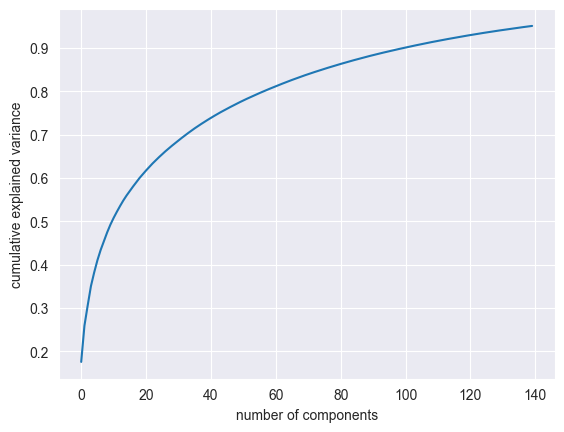

In [89]:
analyser = NightClustering(df=df_variables, feature_settings='efficient')

night_start_hour = 17  # Assuming night starts at 17:00
# Extract Night-Level Features
night_features = analyser.extract_night_level_features(night_start_hour=night_start_hour)  # Finale set uses window of 17:00 to 11:00
print("\nNight-level features extracted:")
print(night_features.head())

# Preprocess Night-Level Features (Scale and PCA)
pca_features = analyser.preprocess_night_features(n_components=0.95)
print("\nPreprocessed PCA features for nights:")
print(pca_features[:5])

# Plot the cumulative explained variance to help decide on the number of components
analyser.plot_pca_cumulative_variance()

The number of features that are selected automatically do not help interpretability, which is important to understanding the patterns behind the clusters. Also, given the number of significant number of features this produces and (even after PCA we reduce to 133 to cover 95% of variance) the elbow curve doesn't have sufficient definition to determine the optimal number of components.

Clustering nights into 2 clusters...
Clustering nights into 3 clusters...
Clustering nights into 4 clusters...
Clustering nights into 5 clusters...
Clustering nights into 6 clusters...


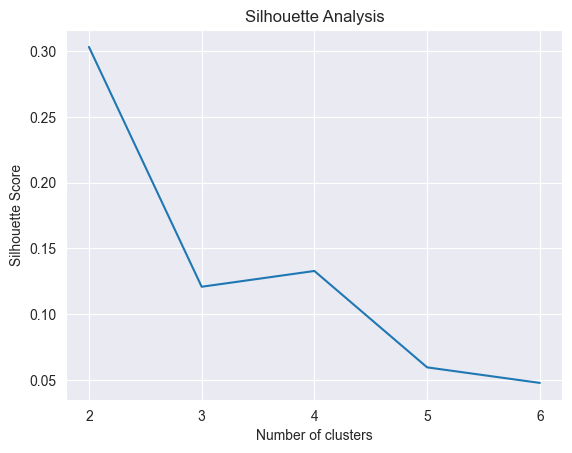

In [90]:
cluster_range = range(2,7)
silhouette_scores = analyser.silhouette_analysis(cluster_range)

Lets look at various cluster sizes to see how they look, comparing their silhouette scores. The Silhouette Coefficient is a measure of how similar an object is to its own cluster compared to other clusters. A higher silhouette score indicates that the object is well matched to its own cluster and poorly matched to neighboring clusters. The silhouette score ranges from -1 to 1, where a score close to 1 indicates that the object is well clustered, a score close to 0 indicates that the object is on or very close to the decision boundary between two neighboring clusters, and a negative score indicates that the object may have been assigned to the wrong cluster.

## Experiment 2: Custom Feature Extraction
The following uses the custom features extracted from the data based on knowledge of the patterns we want to identify in the night periods. This will allow us to see how well the clustering works with a smaller set of custom features that are more interpretable and relevant to the patterns we want to identify.

['iob mean', 'cob mean', 'bg mean', 'cob max', 'iob max']
Extracting night-level features using NoneType settings...


C:\Users\ross\OneDrive\Documents\Masters\Project\masters_project\src\night_analysis.py:145: PerformanceWarning: Adding/subtracting object-dtype array to TimedeltaArray not vectorized.
  night_start_date = temp_df['datetime'].dt.date - pd.to_timedelta((hour < night_start_hour).astype(int), unit='D')
Feature Extraction: 100%|██████████| 30/30 [00:04<00:00,  7.02it/s]


Extracted 68 features for 236 nights.

Night-level features extracted:
                     bg mean__mean  bg mean__variance  bg mean__maximum  \
41131654_2019-09-12     144.233367        5789.894255           270.500   
41131654_2019-09-13     113.905971        1067.657835           187.833   
41131654_2019-09-28     159.728824        1220.006408           235.500   
41131654_2019-09-29     142.326720         898.581728           197.333   
41131654_2019-09-30     148.633179        1588.597821           221.800   

                     bg mean__minimum  bg mean__median  \
41131654_2019-09-12              50.0         128.6665   
41131654_2019-09-13              74.0         105.0000   
41131654_2019-09-28              93.0         162.8335   
41131654_2019-09-29              86.5         141.3330   
41131654_2019-09-30              73.6         137.7500   

                     bg mean__standard_deviation  bg mean__root_mean_square  \
41131654_2019-09-12                    76.091355  

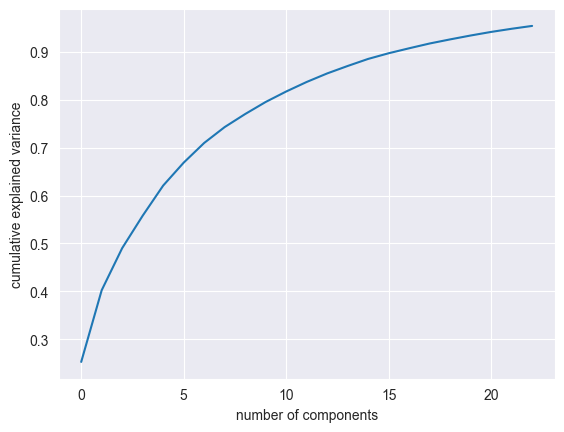

In [91]:
analyser = NightClustering(df=df_variables, feature_settings='custom')
night_features = analyser.extract_night_level_features(night_start_hour=night_start_hour)
print("\nNight-level features extracted:")
print(night_features.head())
pca_features = analyser.preprocess_night_features(n_components=0.95)
analyser.plot_pca_cumulative_variance()

Clustering nights into 2 clusters...
Clustering nights into 3 clusters...
Clustering nights into 4 clusters...
Clustering nights into 5 clusters...
Clustering nights into 6 clusters...


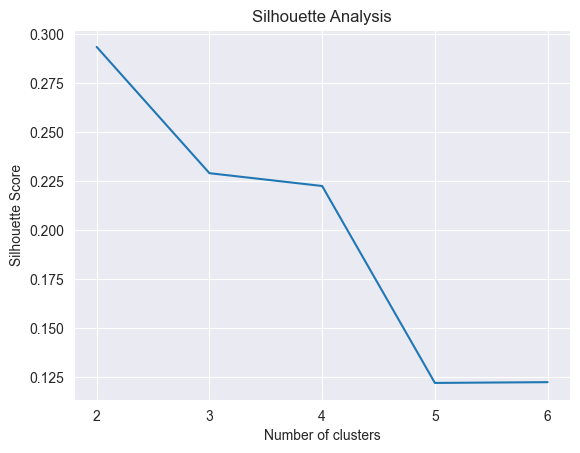

In [92]:
silhouette_scores = analyser.silhouette_analysis(cluster_range)

This is poor again, but not significantly different to the baseline and with notably less features. The custom features are not providing a significant improvement over the efficient features, but they are more interpretable and relevant to the patterns we want to identify. This is a good baseline for the feature extraction process and allows us to see how well the clustering works if we limit the number of components to 2, which is a more manageable number of features to work with and interpret, plus easily visualised in 2D.

Preprocessing night-level features (scaling and PCA)...
PCA reduced dimensions from 66 to 2.
Explained variance: [0.24940039 0.15576603]
Clustering nights into 2 clusters...
Clustering nights into 3 clusters...
Clustering nights into 4 clusters...
Clustering nights into 5 clusters...
Clustering nights into 6 clusters...


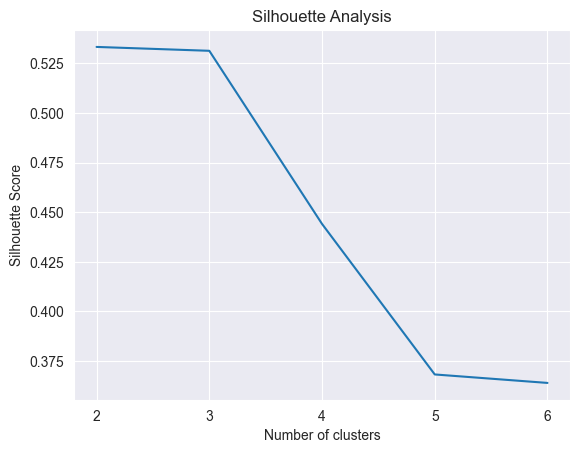

In [93]:
pca_features = analyser.preprocess_night_features(n_components=2)
print(f'Explained variance: {analyser.pca_model.explained_variance_ratio_}')
silhouette_scores = analyser.silhouette_analysis(cluster_range)

Now we have a better silhouette score for 3 clusters, which is a good indication that the clustering is working well. We can now look at the clusters and see how they differ from each other. Let visualise them first, which is easier to do with two components.

Clustering nights into 3 clusters...
Night cluster distribution:
cluster_label
1    151
2     49
0     36
Name: count, dtype: int64


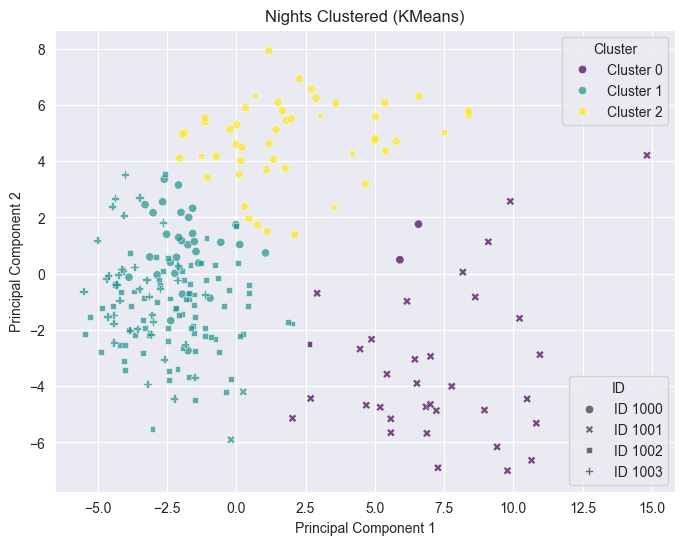

In [134]:
night_clusters = analyser.cluster_nights(n_clusters=3)

This shows that to a notable extent, the clustering is picking up on patterns related to the behaviour of the patients during the night periods. The clusters are not perfectly separated, but there is a some distinction between them. Cluster 2 (in pink) almost entirely represents a single individual, so it will be interesting to see what the upcoming analysis will tell us about the differences between this and the other clusters. The other two clusters are more mixed, with some overlap.

## Centroid Analysis
Now we have established the clusters, we can look at the centroids of each cluster to see what the average feature values are for each cluster. This will help us understand the patterns in the night periods and how they differ between clusters.

In [95]:
# Get characteristics of clusters
cluster_centroids = analyser.get_cluster_centroids()
print("\nCluster Centroids (mean feature values in original scale):")
cluster_centroids.T


Cluster Centroids (mean feature values in original scale):


cluster_label,0,1,2
bg mean__mean,133.174915,146.253292,156.504772
bg mean__variance,1699.397690,1715.101400,2868.546837
bg mean__maximum,221.353000,227.714603,263.433102
bg mean__minimum,80.091667,86.859305,73.999714
bg mean__median,124.172861,140.011702,151.650592
...,...,...,...
iob mean__first_location_of_minimum,0.662908,0.576580,0.415859
iob mean__last_location_of_minimum,0.693474,0.615063,0.454069
iob mean__sample_entropy,0.542247,1.049298,1.615323
iob mean__longest_strike_below_mean,16.111111,13.324503,9.489796


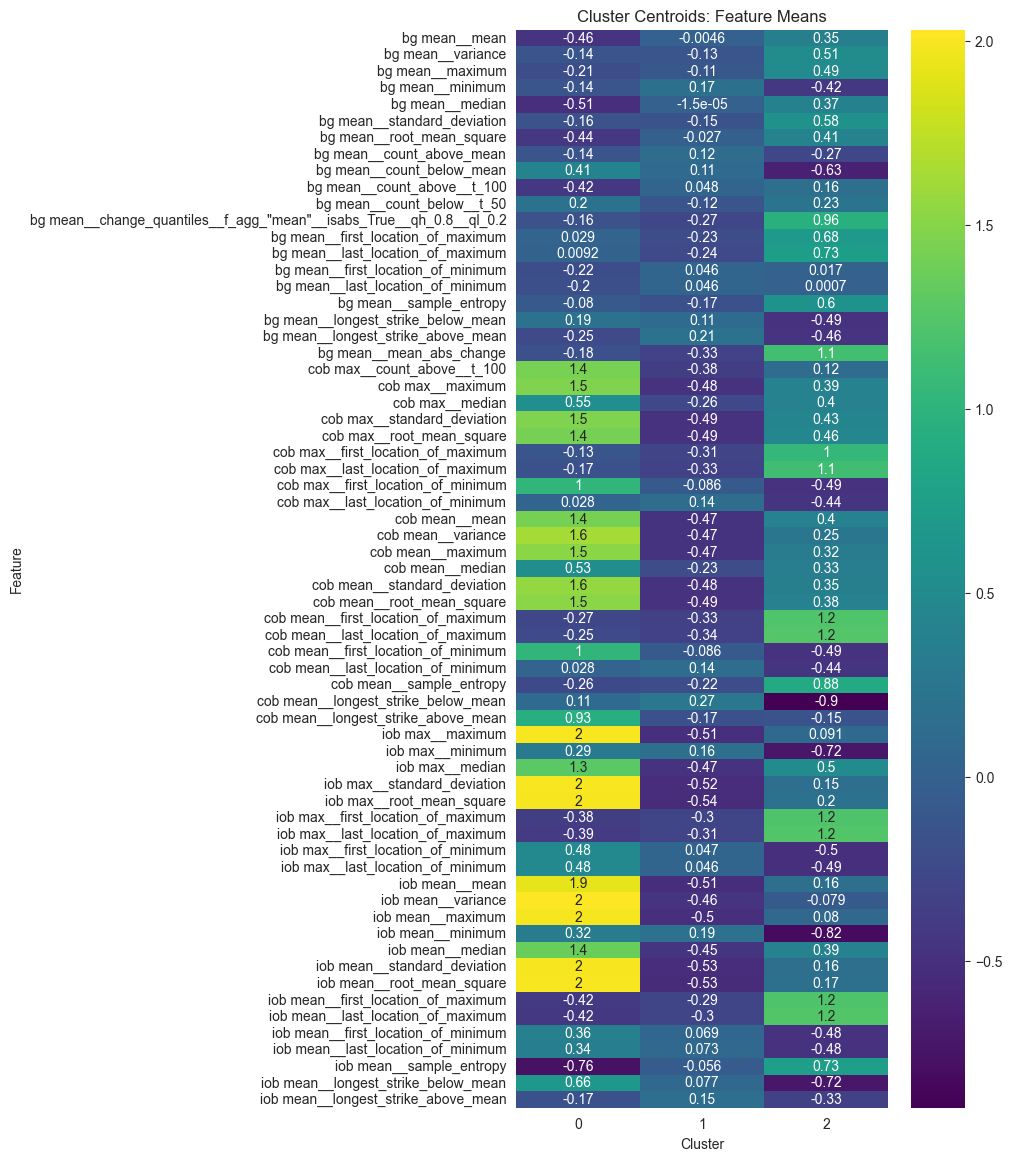

In [96]:
analyser.heatmap_cluster_features()

The heatmap highlights the differences between the clusters, using still scaled values to allow comparison. The largest cluster (cluster 0 at n=36) has relativeely low levels of BG and high levels of IOB and COB and high levels of variance in these. Cluster 1 (n=151) sees BG at low to 'standard' levels and low levels of IOB and COB, with lower than expected variance. Cluster 2 (n=49) has higher levels of BG, later maximums for all variables and low variance as well. This suggests that cluster 0 is a cluster of nights with high levels of activity, cluster 1 is a cluster of nights with low levels of activity, and cluster 2 is a cluster of nights with high levels of BG and low levels of IOB and COB. This is a good indication that the clustering is working well and that the features are providing useful information about the patterns in the night periods.